<a href="https://colab.research.google.com/github/theysee/sberbank_reboot/blob/master/%D0%A8%D0%BA%D0%BE%D0%BB%D0%B0_DA_%D0%9F%D0%BE%D1%82%D0%BE%D0%BA_3_%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6_%D0%BA%D1%80%D1%83%D0%BF%D0%BD%D0%BE%D0%B9_%D1%81%D1%82%D1%80%D0%BE%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9_%D0%BA%D0%BE%D0%BC%D0%BF%D0%B0%D0%BD%D0%B8%D0%B8_%D0%A1%D0%B5%D1%80%D0%B3%D0%B5%D0%B9_%D0%90%D1%80%D1%82%D0%B5%D0%B5%D0%B2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Суть Проекта в том, чтобы проанализировать продажи в крупной строительной компании.
Входные данные в формах Excel. Формируются программой автоматически, а значит всегда постоянны. Некоторые столбцы для анализа продаж они не нужны, поэтому я буду их удалять, чтобы не мешались.

In [0]:
import numpy as np
import pandas as pd
import pymysql
from datetime import datetime, timedelta, date
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%matplotlib inline

In [2]:
# Если не сработает загрузка файлов, дальше есть загрузка в SQL.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Прочитал, что список файлов в Colab не получить, поэтому делаю руками.
!ls "/content/drive/My Drive/Эскроу"

Застройщик_110.xls  Застройщик_140.xls	Застройщик_146.xls  Застройщик_176.xls
Застройщик_120.xls  Застройщик_141.xls	Застройщик_170.xls  Застройщик_28.xls


In [0]:
# Функция для наведения красоты.
# Удаляем лишние данные, обрезаем сверху и снизу тех ячейки в Excel.
def pars(data_read):
  contract = data_read.iloc[5,6]
  contract = contract.split(' ')
  contract = contract[-3:-2]
  contract = int(contract[0])
  data_read.drop(data_read.columns[[0, 4, 5, 6, 7, 8, 9, 10, 11]], axis='columns', inplace=True)
  data_read.drop([0,1,2,3,4,5,6,7], inplace=True)
  data_read.columns = ['Date_open_escrow', 'Depo_summ', 'Date_pay']
  data_read['Date_open_escrow'] =  pd.to_datetime(data_read['Date_open_escrow'], format='%Y-%m-%d')
  data_read['Date_pay'] =  pd.to_datetime(data_read['Date_pay'], format='%Y-%m-%d')
  data_read['Contract'] = contract
  return data_read

In [21]:
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_110.xls')
df = pars(data_read)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_140.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_146.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_176.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_120.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_141.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_170.xls')
df = df.append(pars(data_read), ignore_index = True)
data_read = pd.read_excel('/content/drive/My Drive/Эскроу/Застройщик_28.xls')
df = df.append(pars(data_read), ignore_index = True)
df.dropna(inplace=True)
df['Depo_summ'] = df['Depo_summ'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1818 entries, 0 to 1845
Data columns (total 4 columns):
Date_open_escrow    1818 non-null datetime64[ns]
Depo_summ           1818 non-null int64
Date_pay            1818 non-null datetime64[ns]
Contract            1818 non-null int64
dtypes: datetime64[ns](2), int64(2)
memory usage: 71.0 KB


In [22]:
!pip install PyMySQL

In [0]:
DB_HOST = '89.223.95.235'
DB_USER = 'student_12'
DB_USER_PASSWORD = 'student_12'
DB_NAME = 'student_12'
conn = pymysql.connect(DB_HOST, DB_USER, DB_USER_PASSWORD, DB_NAME)

In [31]:
pd.read_sql_query("show tables", conn)

,Tables_in_student_12
0,sales


In [0]:
#query = "DROP TABLE IF EXISTS Sales"
#conn.cursor().execute(query)
#conn.commit()

In [0]:
# По идее, ключ не нужен, но как SQL без ключа.
query = """
  CREATE TABLE IF NOT EXISTS Sales (
    Sales_id INT AUTO_INCREMENT PRIMARY KEY,
    Date_open_escrow DATETIME,
    Depo_summ NUMERIC,
    Date_pay DATETIME,
    Contract INT
    )
""" 

conn.cursor().execute(query)
conn.commit()

In [0]:
queries = []

for index, row in df.iterrows():
    querie = f'''INSERT INTO Sales (Date_open_escrow, Depo_summ, Date_pay, Contract) VALUES ('{row[0]}', '{row[1]}', '{row[2]}', '{row[3]}')'''
    queries.append(querie)

for q in queries:
  conn.cursor().execute(q)
#conn.commit()

In [48]:
# Записей 1818, значит всё в порядке.
df = pd.read_sql_query('''SELECT * FROM Sales''', conn)
df

,Sales_id,Date_open_escrow,Depo_summ,Date_pay,Contract
0,1,2019-06-28 16:08:00,3048000.0,2019-09-30,110
1,2,2019-06-28 09:13:00,2048000.0,2019-08-31,110
2,3,2019-06-28 10:45:00,2448000.0,2019-08-31,110
3,4,2019-06-28 09:40:00,98000.0,2021-09-30,110
4,5,2019-06-28 16:47:00,3700000.0,2019-12-31,110
...,...,...,...,...,...
1813,1814,2020-01-30 12:28:25,3520000.0,2021-09-30,28
1814,1815,2020-02-04 09:19:23,5150000.0,2021-09-30,28
1815,1816,2020-01-30 11:23:49,3150000.0,2021-09-30,28
1816,1817,2020-01-31 11:07:27,4190000.0,2021-09-30,28


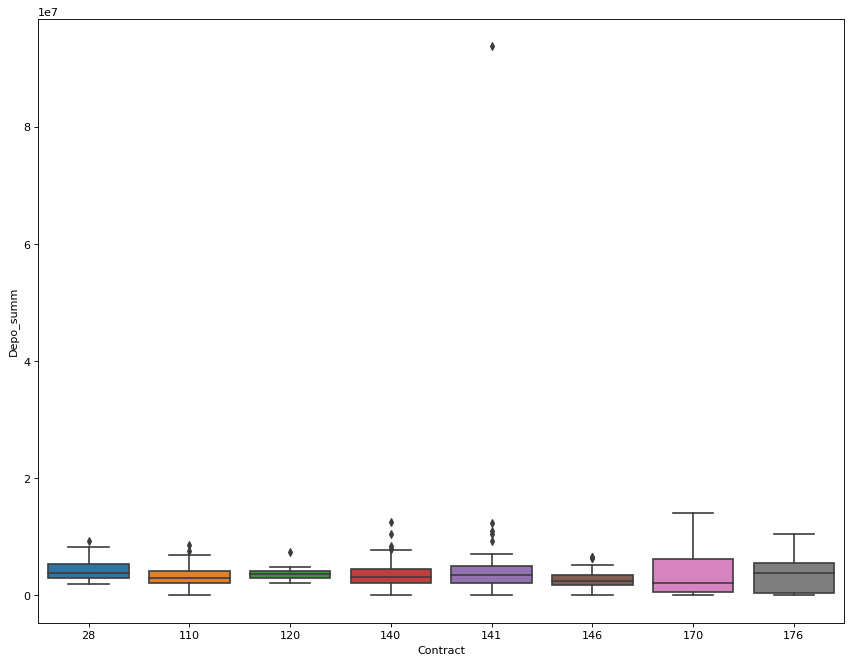

In [30]:
# Используем ящик, чтобы понять, какой вообще разброс цены.
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(x='Contract', y='Depo_summ', data=df, notch=False)
# Видим выброс. Это не ошибка, такая продажа действительно была.

In [14]:
# Та самая сумма.
df['Depo_summ'].max()

93782826.0

In [34]:
# Посмотрим статистику по Датафрейму
df.describe()

,Sales_id,Depo_summ,Contract
count,1818.000000,1.818000e+03,1818.000000
mean,909.500000,3.470487e+06,130.777228
std,524.955712,3.154061e+06,49.057146
min,1.000000,1.000000e+00,28.000000
25%,455.250000,1.987401e+06,110.000000
50%,909.500000,3.400000e+06,141.000000
75%,1363.750000,4.950000e+06,170.000000
max,1818.000000,9.378283e+07,176.000000


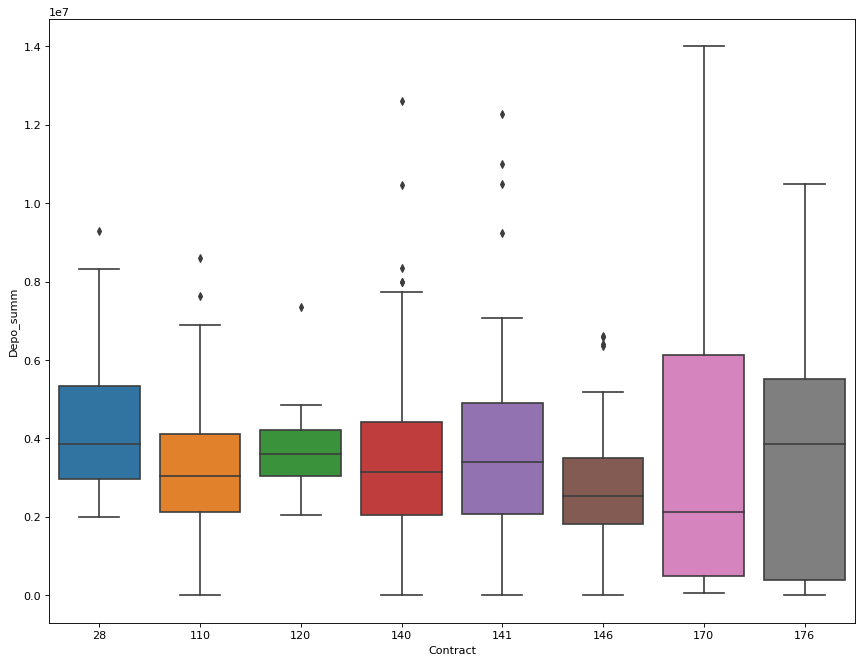

In [36]:
# Построим график без этого выброса.
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(x='Contract', y='Depo_summ', data=df[df['Depo_summ'] < df['Depo_summ'].max()], notch=False)

Компания работает в разных городах России. Проекты тоже разные и продаются с разной динамикой и успехом.
Выводы по графику:
Наиболее стабильный размер счета эскроу в договоре 120 и наиболее нестабильные в 170 и 176. С точки зрения бизнеса, стоит присмотреться к проектам, где продажи нестабильны.

([<matplotlib.axis.XTick at 0x7f224436afd0>,
 <a list of 8 Text xticklabel objects>)

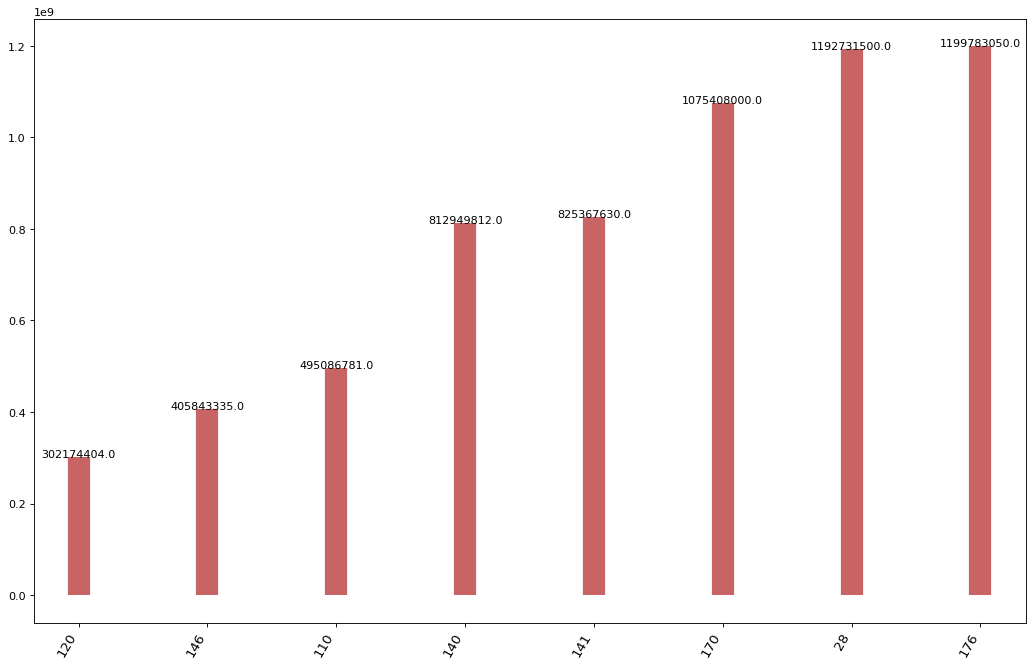

In [78]:
# Посмотрим на суммы продаж по договорам.
df1 = df.groupby('Contract').aggregate(sum)
df1.sort_values('Depo_summ', inplace=True)
df1.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
ax.vlines(x=df1.index, ymin=0, ymax=df1.Depo_summ, color='firebrick', alpha=0.7, linewidth=20)
for i, Depo_summ in enumerate(df1.Depo_summ):
    ax.text(i, Depo_summ+1, round(Depo_summ, 1), horizontalalignment='center')
plt.xticks(df1.index, df1.Contract, rotation=60, horizontalalignment='right', fontsize=12)

([<matplotlib.axis.XTick at 0x7f224402d588>,
 <a list of 8 Text xticklabel objects>)

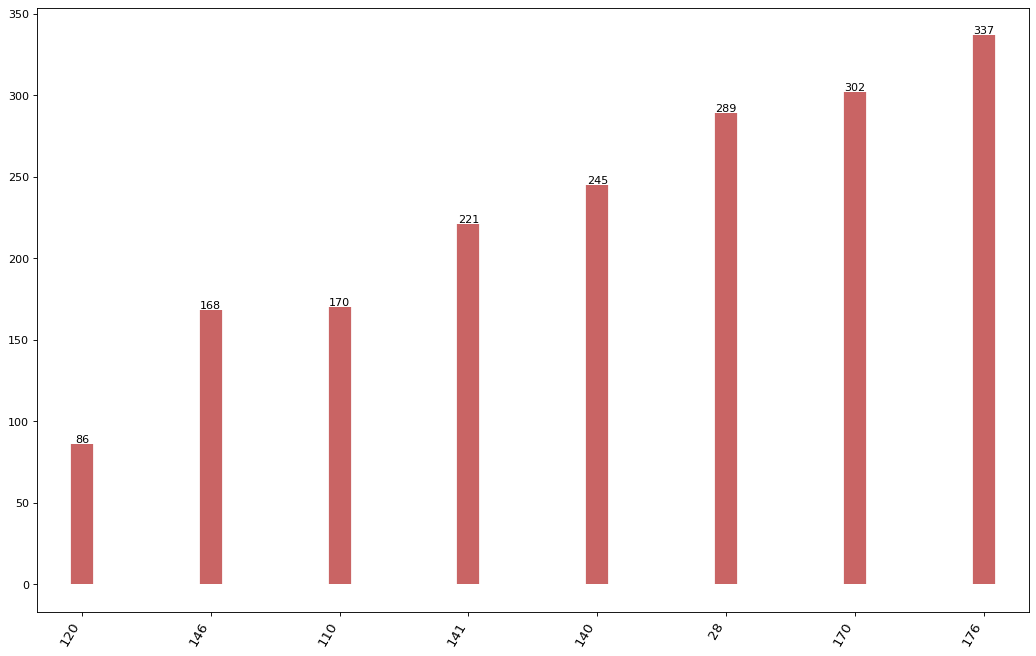

In [104]:
# А теперь на количество продаж по договорам.
df1 = df.groupby('Contract')['Depo_summ'].agg(['sum', 'count'])
df1.sort_values('count', inplace=True)
df1.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)
ax.vlines(x=df1.index, ymin=0, ymax=df1['count'], color='firebrick', alpha=0.7, linewidth=20)
for i, count in enumerate(df1['count']):
    ax.text(i, count+1, round(count, 1), horizontalalignment='center')
plt.xticks(df1.index, df1.Contract, rotation=60, horizontalalignment='right', fontsize=12)

Выводы:
Видим, что некоторые договоры не совпадают в последовательности между суммой на эскроу и количеством продаж.
Например, договор 28 и 141 при меньших продажах демонстрируют большие суммы на счетах.

In [100]:
df.head()

,Sales_id,Date_open_escrow,Depo_summ,Date_pay,Contract
0,1,2019-06-28 16:08:00,3048000.0,2019-09-30,110
1,2,2019-06-28 09:13:00,2048000.0,2019-08-31,110
2,3,2019-06-28 10:45:00,2448000.0,2019-08-31,110
3,4,2019-06-28 09:40:00,98000.0,2021-09-30,110
4,5,2019-06-28 16:47:00,3700000.0,2019-12-31,110


In [112]:
# А теперь посмотрим динамику во времени.
df1 = df.groupby(['Date_pay', 'Contract'])['Depo_summ'].agg(['sum', 'count'])
df1.head()

,,sum,count
Date_pay,Contract,,
2018-02-20,170,3900000.0,1
2018-02-28,170,6000000.0,1
2018-08-26,170,5370000.0,1
2018-09-20,170,3250000.0,1
2018-09-25,170,5390000.0,1


In [0]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(df1['Date_pay'], df1[df1['Contract'] == '170'])

In [126]:
df1['Contract'] == 170

KeyError: ignored